In [721]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
from scipy.spatial.distance import cdist
from sklearn import cluster
%matplotlib inline

# Data preperation

In [722]:
#read in whole data excluding Linz csv file :
#df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcourse_excl_Linz.csv")
#read in only Ulm data csv file:
df = pd.read_csv("/Users/tamo/Documents/Studium/WS 20-21/Master thesis/Data/Intelliekon/consumption_loadcurse_Ulm.csv")

In [723]:
#convert to datetime format and ad new "date" and "hour"-column in datetime format

df["datetime"] = pd.to_datetime(df["Datum"],dayfirst = True) + df["Hour_of_Day"].astype("timedelta64[h]")
df.datetime.dt.tz_localize("UTC").dt.tz_convert("Europe/Berlin")

#df["date"]= df['datetime'].apply(lambda x: x.date)
df["day_of_year"] = df["datetime"].apply(lambda x: x.timetuple().tm_yday)
df["hour"]= df['datetime'].apply(lambda x: x.hour)
df.head()


,datetime,ID,Fall_ge1,IdCons,Datum,Hour_of_Year,Season,Weekday,Hour_of_Day,Fehlerfeld,Daten_Herkunft,Electricity_Demand,dateyear,day_of_year,hour
0,2009-05-01 01:00:00,84544,149,107953001,1/5/2009,2881,0,1,1,0,Ulm,295.0,2009,121,1
1,2009-05-02 01:00:00,84545,149,107953001,2/5/2009,2905,0,2,1,0,Ulm,363.0,2009,122,1
2,2009-05-03 01:00:00,84546,149,107953001,3/5/2009,2929,0,2,1,0,Ulm,316.0,2009,123,1
3,2009-05-04 01:00:00,84547,149,107953001,4/5/2009,2953,0,1,1,0,Ulm,331.0,2009,124,1
4,2009-05-05 01:00:00,84548,149,107953001,5/5/2009,2977,0,1,1,0,Ulm,39.0,2009,125,1


In [724]:
#normalisation:
df['max_energy'] = df.groupby(['Fall_ge1'])['Electricity_Demand'].transform(max)
df['norm_energy'] = df['Electricity_Demand'] / df['max_energy']

In [725]:
#Meteorological seasons:
#winter
sdate_wi = date(2009, 12, 1)   # start date
edate_wi = date(2010, 2, 28)   # end date
#spring
sdate_sp = date(2010, 3, 1)   # start date
edate_sp = date(2010, 5, 31)   # end date
#summer
sdate_su = date(2010, 6, 1)   # start date
edate_su = date(2010, 8, 31)   # end date
#Fall
sdate_fa = date(2009, 9, 1)   # start date
edate_fa = date(2009, 11, 30)   # end date

In [726]:
#filter df by season:
df_fa = df[(df["datetime"] > str(sdate_fa)) & (df["datetime"] <= str(edate_fa))]
df_wi = df[(df["datetime"] > str(sdate_wi)) & (df["datetime"] <= str(edate_wi))]
df_sp = df[(df["datetime"] > str(sdate_sp)) & (df["datetime"] <= str(edate_sp))]
df_su = df[(df["datetime"] > str(sdate_su)) & (df["datetime"] <= str(edate_su))]

In [727]:
df_sp.shape

(134856, 17)

In [728]:
df_su.shape

(132552, 17)

In [729]:
df_wi.shape

(129240, 17)

In [730]:
df_fa.shape

(131928, 17)

In [731]:
#split dataframes into weekday and weekend days
df_fa_week=df_fa[df_fa["Weekday"]==1]
df_fa_wknd=df_fa[df_fa["Weekday"]==2]
df_wi_week=df_wi[df_wi["Weekday"]==1]
df_wi_wknd=df_wi[df_wi["Weekday"]==2]
df_sp_week=df_sp[df_sp["Weekday"]==1]
df_sp_wknd=df_sp[df_sp["Weekday"]==2]
df_su_week=df_su[df_su["Weekday"]==1]
df_su_wknd=df_su[df_su["Weekday"]==2]

In [732]:
df.set_index("datetime", inplace = True)

# Functions for clustering

In [733]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

In [734]:
#def plot_clustering_results()

In [735]:
#def cluster_overview(cluster_centers)
#    sort
#    plt.plot(fall_week[x],label="Cluster " + str(x + 1))

In [736]:
# for x in range(0,5,1):
#     plt.plot(fall_week[x],label="Cluster " + str(x + 1))
# plt.legend()
# plt.title("Fall weekdays")
# plt.ylabel("normalized consumption")
# plt.xlabel("hour")

# Fall

### Fall weekday 

In [737]:
red_df=df_fa_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#check if cluster column is in kmeans_df and delet it: (Avoiding error with too many parameters for clustering algorithm)
if "cluster" in kmeans_df:
    del kmeans_df["cluster"]

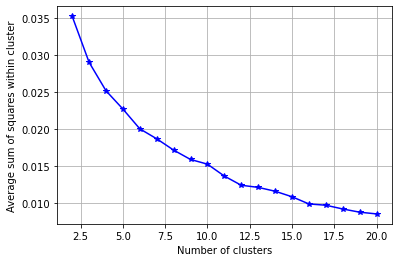

In [738]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [739]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 5 corresponds to the element with index 3
clustering = k_res[3]

In [740]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [741]:
kmeans_df['cluster'] = list(lut[clustering.labels_])
kmeans_df['cluster']

Fall_ge1
149     0
151     0
152     0
153     1
155     3
       ..
1104    0
1105    1
1107    0
1108    1
1109    0
Name: cluster, Length: 62, dtype: int64

In [742]:
clust_cent = clustering.cluster_centers_


In [743]:
kmeans_df[kmeans_df["cluster"] == 4]

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,cluster
Fall_ge1,,,,,,,,,,,,,,,,,,,,,
157,0.108649,0.092120,0.066999,0.058583,0.052924,0.056870,0.046944,0.052151,0.068690,0.092124,...,0.230313,0.268953,0.289055,0.271999,0.205662,0.198467,0.198015,0.183821,0.132238,4
178,0.094279,0.067798,0.056322,0.055318,0.055942,0.054760,0.097003,0.084560,0.093341,0.091320,...,0.301819,0.282363,0.291182,0.324283,0.327469,0.308861,0.313435,0.319419,0.211771,4
1094,0.123701,0.078975,0.067908,0.053907,0.042397,0.055013,0.066604,0.192523,0.130841,0.144435,...,0.152392,0.138691,0.167301,0.220508,0.247948,0.267351,0.327772,0.295817,0.201853,4


Text(0.5, 0, 'hour')

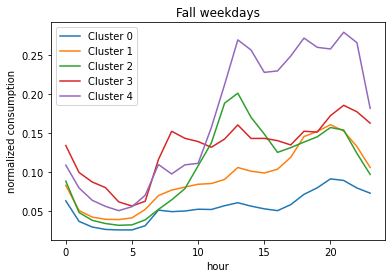

In [744]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Fall weekend 

In [745]:
red_df=df_fa_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df

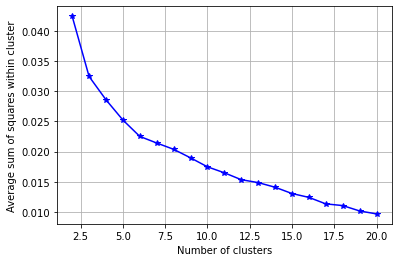

In [746]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [747]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [748]:
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [749]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [750]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

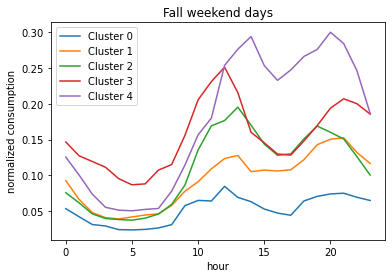

In [751]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Fall weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Winter

### Winter weekdays

In [752]:
red_df=df_wi_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

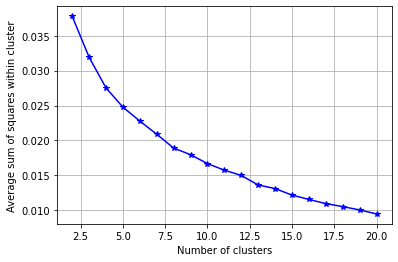

In [753]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [754]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [755]:
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [756]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [757]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

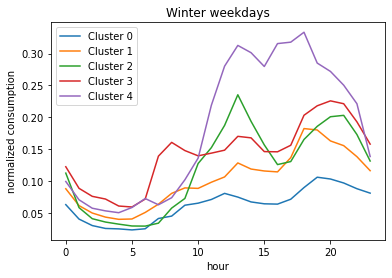

In [758]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Winter weekend days

In [759]:
red_df=df_wi_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

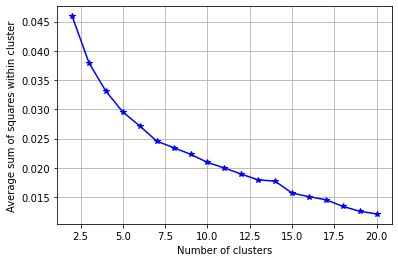

In [760]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [761]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [762]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [763]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [764]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

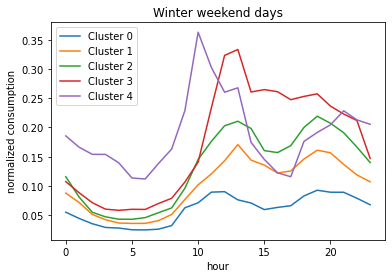

In [765]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Winter weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Spring

### Spring weekdays

In [766]:
red_df=df_sp_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

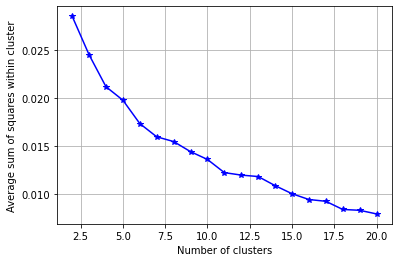

In [767]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [768]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [769]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [770]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [771]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

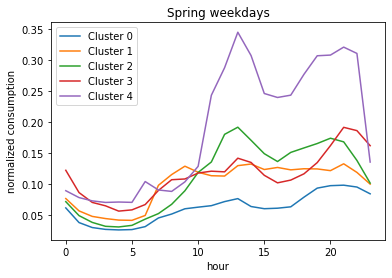

In [772]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Spring weekend days

In [773]:
red_df=df_sp_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

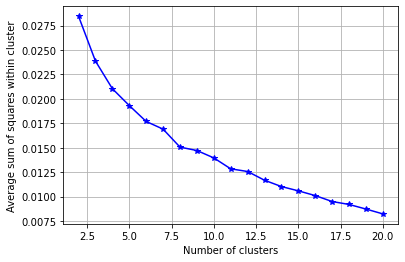

In [774]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [775]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [776]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [777]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [778]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

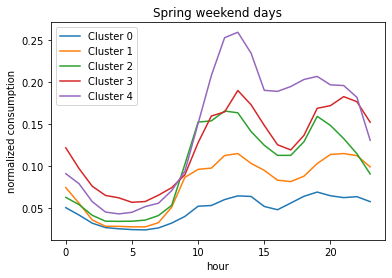

In [779]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Spring weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Summer

### Summer weekdays

In [780]:
red_df=df_su_week[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

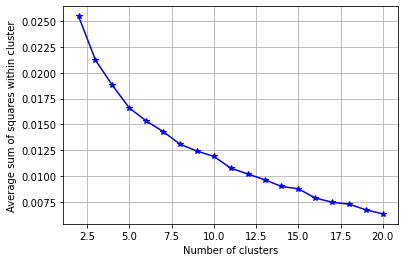

In [781]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [782]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [783]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [784]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [785]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

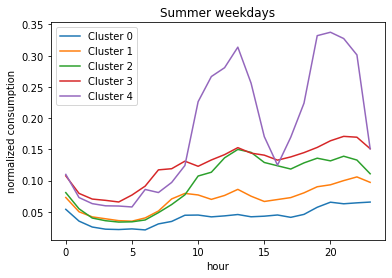

In [786]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Summer weekdays")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

### Summer weekend days

In [787]:
red_df=df_su_wknd[["Fall_ge1","day_of_year","hour","norm_energy"]]
piv_df = pd.pivot_table(red_df,index = ["Fall_ge1","day_of_year"],columns = "hour",values="norm_energy")
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby("Fall_ge1").mean()
#grp_df.reset_index(inplace = True)
del grp_df["day_of_year"]
kmeans_df = grp_df
#del kmeans_df["Fall_ge1"]
#grp_df

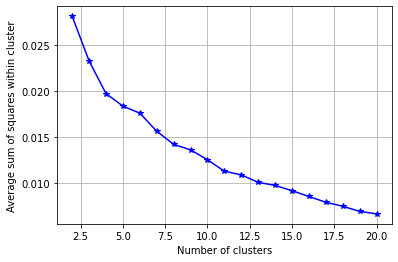

In [788]:
k_algs, k_res = elbow_method(kmeans_df, 2, 20)

In [789]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 7 corresponds to the element with index 5
clustering = k_res[3]

In [790]:
#reassign cluster numbers so the cluster numbers are from lowest to highest mean
k=5
idx = np.argsort(clustering.cluster_centers_.mean(axis = 1))
lut = np.zeros_like(idx)
lut[idx] = np.arange(k)

In [791]:
kmeans_df['cluster'] = list(lut[clustering.labels_])

In [792]:
clust_cent = clustering.cluster_centers_

Text(0.5, 0, 'hour')

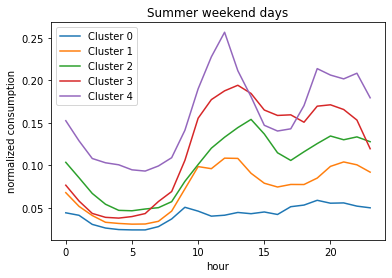

In [793]:
for x in range(0,5,1):
    plt.plot(clust_cent[idx[x]],label = "Cluster " + str(x))  
plt.legend()
plt.title("Summer weekend days")
plt.ylabel("normalized consumption")
plt.xlabel("hour")

# Additional methods 

In [794]:
#multiline plot:
def multiline_hourly_plot(dataset, avg = None, ycol = 'Electricity_Demand', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()
    
    return fig

In [795]:
def clusters_visualisation(grp_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = grp_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [796]:
clusters_visualisation(kmeans_df, id_vars = ["Fall_ge1",'cluster'], value_vars = list(kmeans_df.columns[0:23]))
#plt.savefig('wknd_7_norm_year.png')

KeyError: "The following 'id_vars' are not present in the DataFrame: ['Fall_ge1']"

## Closer look at a cluster

In [ ]:
# cl4_df = kmeans_df[kmeans_df["cluster"]==4]

In [ ]:
# cl4_lst = list(cl4_df["Fall_ge1"].unique())
# cl4_lst

In [ ]:
# df[df["Fall_ge1"].isin(cl4_lst)].loc["2010-05-02"].groupby("Fall_ge1").Electricity_Demand.plot()

In [ ]:
# cl6_df = df[df["Fall_ge1"].isin(cl6_lst)]
# cl6_df["Daten_Herkunft"].unique()